2025-03-31 09:35:37.574395: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 09:35:37.606598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 09:35:37.673784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743406537.749879 2591993 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743406537.771321 2591993 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 09:36:08.660299: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Fa

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 204ms/step - loss: 0.0217 - val_loss: 0.0113
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - loss: 0.0112 - val_loss: 0.0102
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 192ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 193ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 208ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 12

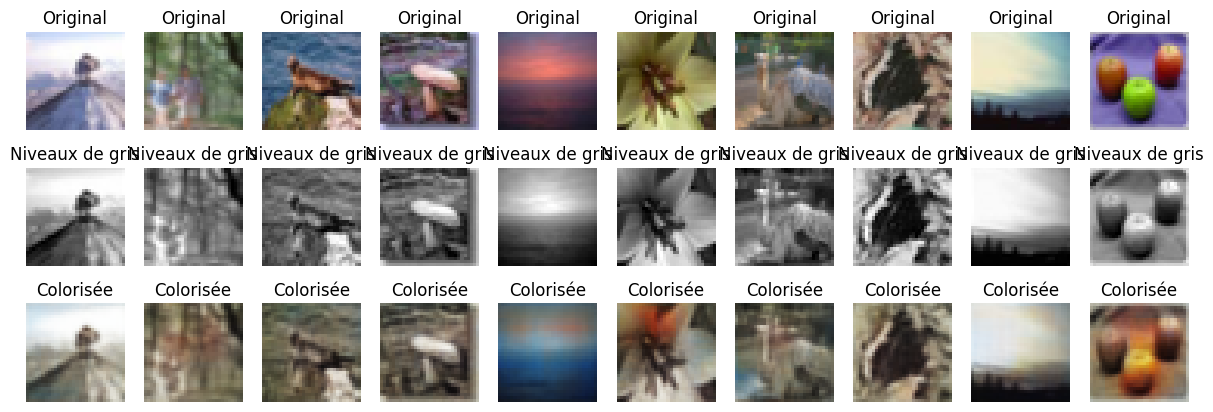

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Chargement des données CIFAR-100
(x_train, _), (x_test, _) = cifar100.load_data()

# Normaliser les images entre 0 et 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Conversion des images en niveaux de gris pour les entrées
def rgb_to_grayscale(images):
    return np.dot(images[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]  # Pondérations standard pour niveaux de gris

x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

# Séparation des ensembles d'entraînement et de validation
x_train_gray, x_val_gray, x_train, x_val = train_test_split(x_train_gray, x_train, test_size=0.2, random_state=42)

# Dimensions des données
input_shape = x_train_gray.shape[1:]  # (32, 32, 1)
output_shape = x_train.shape[1:]      # (32, 32, 3)

# Construiction du modèle Encoder-Decoder
# Encodeur : réduiction la dimension et extrait les caractéristiques
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Décodeur : reconstruction l'image en couleur
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Modèle complet
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(
    x_train_gray, x_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val_gray, x_val)
)

# Testons le modèle sur des données de test
predicted_images = autoencoder.predict(x_test_gray)

# Affichage des images originales, en niveaux de gris et colorisées côte à côte
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(15, 5))
for i in range(n):
    # Image originale
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.axis("off")
    ax.set_title("Original")

    # Image en niveaux de gris
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_gray[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title("Niveaux de gris")

    # Image colorisée
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predicted_images[i])
    ax.axis("off")
    ax.set_title("Colorisée")
plt.show()


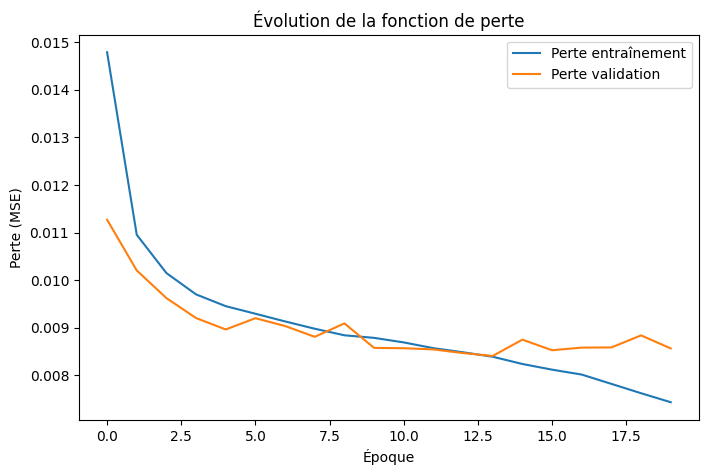

In [9]:
# Affichage de la courbe de perte
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.title("Évolution de la fonction de perte")
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcul du MSE moyen entre les images originales et les images prédites
mse = np.mean([mean_squared_error(x_test[i].flatten(), predicted_images[i].flatten()) for i in range(len(x_test))])

# Fonction pour calculer le PSNR
def psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100  # Valeur maximale possible
    PIXEL_MAX = 1.0  # Normalisation entre 0 et 1
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# Calcul du PSNR moyen
psnr_score = np.mean([psnr(x_test[i], predicted_images[i]) for i in range(len(x_test))])

print(f"MSE moyen sur les images de test : {mse:.5f}")
print(f"PSNR moyen : {psnr_score:.2f} dB")


MSE moyen sur les images de test : 0.00881
PSNR moyen : 22.48 dB


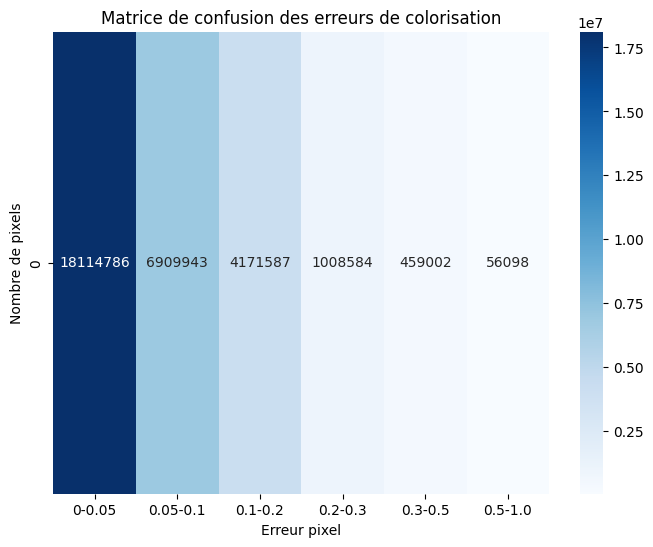

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des différences pixel par pixel
diff = np.abs(x_test - predicted_images)

# On quantifie la différence en classes (erreurs faibles, moyennes, fortes)
diff_classes = np.digitize(diff, bins=[0.05, 0.1, 0.2, 0.3, 0.5, 1.0])

# Création de la matrice de confusion des différences
conf_matrix, _ = np.histogram(diff_classes, bins=6, range=(0, 6))

# Affichage sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix.reshape(1, -1), annot=True, fmt="d", cmap="Blues", xticklabels=["0-0.05", "0.05-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-1.0"])
plt.xlabel("Erreur pixel")
plt.ylabel("Nombre de pixels")
plt.title("Matrice de confusion des erreurs de colorisation")
plt.show()


In [13]:
#Auteur Ibrahim Amza Coulibaly élève ingénieur mathématiques Appliquées et modélisation (3A MAM)